# I. Import libraries and prepare data

## 1. Install and import libraries

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

In [ ]:
# !pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:00


In [2]:
import os
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import random
import cv2
import timm
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

## 2. Prepare data

### 2.1. Download, unzip dataset

In [3]:
# https://drive.google.com/file/d/1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM/view
!gdown --id 1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM
!unzip -q icdar2003.zip

/bin/bash: gdown: command not found


In [4]:
# If the dataset already available, skip the above line and run this line
!unzip -q icdar2003.zip

replace SceneTrialTrain/apanar_06.08.2002/IMG_1247.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### 2.2. Extract Data from XML and Store in New Folder

#### 2.2.1. Extract function

In [3]:
def extract_data_from_xml (root_dir):
  """
  Extract data from the file words.xml in the IC03 dataset

  This function is used to extract information from file .xml, including:
  image paths, image sizes, image labels and bounding boxes

  Parameters:
    root_dir (str): the path to the root directory of the dataset

  Returns:
    tuple: contains 4 lists, they are: mage paths, image sizes, image labels and bounding boxes
  """
      # Create path to the file words.xml
  xml_path = os.path.join(root_dir, 'words.xml')
  #Parse xml file
  tree = ET.parse(xml_path)
  # Read the root tag of the xml file
  root = tree.getroot()

  # Initialize empty list to store data
  img_paths = []
  img_sizes = []
  img_labels = []
  bboxes = []

  # Loop through each image tag <image>
  for img in root:
      # Initialize empty list to store bounding boxes and the label of image
      bbs_of_img = []
      labels_of_img = []

      # Loop through each boundingbox tag
      for bbs in img.findall('taggedRectangles'):
          for bb in bbs:
              # Skip labels that are not in the alphabet or not number
              if not bb[0].text.isalnum():
                  continue

              # Skip labels with unicode characters
              if 'é' in bb[0].text.lower() or 'ñ' in bb[0].text.lower():
                  continue

              # Append bbox information to list bbs_of_img
              # Format bbox: (xmin, ymin, bbox_width, bbox_height)
              bbs_of_img.append(
                  [
                      float(bb.attrib['x']),
                      float(bb.attrib['y']),
                      float(bb.attrib['width']),
                      float(bb.attrib['height'])
                  ]
              )
              # Append label to list labels_of_img (converted to lowercase)
              labels_of_img.append(bb[0].text.lower())

      # Append path of the current image to list img_paths
      img_path = os.path.join(root_dir, img[0].text)
      img_paths.append(img_path)
      # Append image size to list img_sizes
      img_sizes.append((int(img[1].attrib['x']), int(img[1].attrib['y'])))
      # Append list of bounding boxes to list bboxes
      bboxes.append(bbs_of_img)
      # Append labels list to list img_labels
      img_labels.append(labels_of_img)

  return img_paths, img_sizes, img_labels, bboxes

In [4]:
# Call the function extract_data_from_xml to get data
dataset_dir = '/Users/macos/Desktop/Nhat?/AIO 2023/Main Lesson/Module 6/Scence Text Project/SceneTrialTrain'
img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml(dataset_dir)

In [5]:
print (f"Total image: {len(img_paths)}")
print (f"Total bounding boxes: {sum([len(bbs) for bbs in bboxes])}")

Total image: 250
Total bounding boxes: 1097


#### 2.2.2. Plot an example

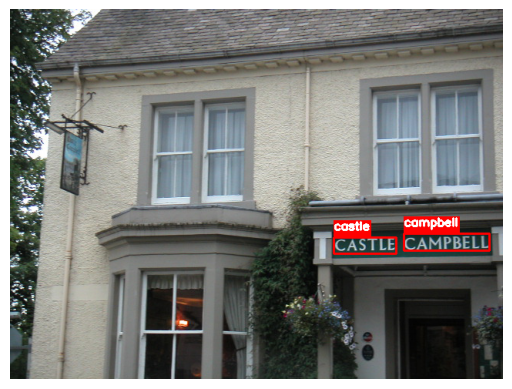

In [6]:
def plot_image_with_bbs (img_path, bbs, labels):
  """
  Visualize bouding box and label on image

  Parameters:
    img_paths (str): Image path
    bbs (list): List of bounding boxes in image
    labels (list): List of labels in  image
  """

  # Read image
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Loop through each bounding box
  for idx, bb in enumerate(bbs):
    # Visualize bounding box on image
    start_point = (int(bb[0]), int(bb[1]))
    end_point = (int(bb[0] + bb[2]), int(bb[1] + bb[3]))
    color = (255, 0, 0)
    thickness = 2
    img = cv2.rectangle (img, start_point, end_point, color, thickness)

    # Visualize label next to bounding box
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = (255, 255, 255)
    line_type =  2
    text_thickness = 2
    label = labels[idx]
    text_size, _ = cv2.getTextSize(label, font, font_scale, text_thickness)

    label_background_start = (int(bb[0]), int(bb[1] - text_size[1] - 10))
    label_background_end = (int(bb[0] + text_size[0]), int(bb[1]))
    img = cv2.rectangle(img, label_background_start, label_background_end, color, cv2.FILLED)


    cv2.putText(
        img,
        label,
        (int(bb[0]), int(bb[1] - 10)),
        font,
        font_scale,
        font_color,
        text_thickness,
        line_type
    )

  # Show image
  plt.imshow(img)
  plt.axis('off')
  plt.show ()


# Random chỉ mục của một ảnh bất kỳ để visualize
i = random.randint(0, len(img_paths))
plot_image_with_bbs(img_paths[i], bboxes[i], img_labels[i])


#### 2.2.3. Store all bounding boxes as a new dataset

In [7]:
def split_bounding_boxes (img_paths, img_labels, bboxes, save_dir):
  """
  Build folder contains data  for Text Recognition.

  This function will create a folder save_dir, then save images cropped from the bounding boxes coordinate.
  Label of each bounding box will be save seperately to the file labels.txt

  Parameters:
    img_paths (list): list of the paths of the images.
    img_labels (list): list contains list of the labels of one image.
    bboxes (list): List contains list of bounding boxes of the images.
    save_dir (str): Path to the target directory
  """

  # Create folder to store data
  os.makedirs(save_dir, exist_ok=True)

  # Initialize count variable  and empty list to store labels
  count = 0
  labels = []

  # Loop through images paths, image labels and bboxes
  for img_path, img_label, bbs in zip (img_paths, img_labels, bboxes):
    # Read image
    img = Image.open(img_path)

    # Loop through each label and bbox
    for label, bb in zip (img_label, bbs):
      # Crop image by bounding box
      cropped_img = img.crop((bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]))

      # Skip the case where 90% content of the picture is black or white
      if np.mean(cropped_img) < 35 or np.mean(cropped_img) > 220:
        continue

      # Skip the case where image width < 10 or height < 10
      if cropped_img.size[0] < 10 or cropped_img.size[1] < 10:
        continue

      # Skip if the length  of the label < 3
      if len(label) < 3:
        continue

      # Give name to cropped image and save to save_dir
      filename = f"{count:06d}.jpg"
      cropped_img.save(os.path.join(save_dir, filename))

      new_img_path = os.path.join(save_dir, filename)

      # Append new label format to list labels
      # Format: img_path\tlabel
      label = new_img_path + '\t' + label

      labels.append(label)  # Append label to the list

      count += 1

  print(f"Created {count} images")

  # Put the list of labels into the labels.txt file
  with open(os.path.join(save_dir, 'labels.txt'), 'w') as f:
      for label in labels:
          f.write(f"{label}\n")

In [8]:
save_dir = 'datasets/ocr_dataset'
split_bounding_boxes(img_paths, img_labels, bboxes, save_dir)

Created 928 images


### 2.3. Read Dataset

In [9]:
# Read data from created folder
root_dir = save_dir

img_paths = []
labels = []

with open(os.path.join(root_dir, 'labels.txt'), 'r') as f:
    for label in f:
        labels.append(label.strip().split('\t')[1])
        img_paths.append(label.strip().split('\t')[0])

print(f"Total images: {len(img_paths)}")

Total images: 928


### 2.4. Prepare vocabulary

In [10]:
# Lấy tất cả các kí tự trong danh sách labels
letters = [char.split(".")[0].lower() for char in labels]
letters = "".join(letters)
# Lọc kí tự trùng
letters = sorted(list(set(list(letters))))

# Chuyển list kí tự thành string
chars = "".join(letters)

# Thêm kí tự "blank" vào bộ vocab
blank_char = '-'
chars += blank_char
# Tính vocab size
vocab_size = len(chars)

print(f'Vocab: {chars}')
print(f'Vocab size: {vocab_size}')

Vocab: 0123456789abcdefghijklmnopqrstuvwxyz-
Vocab size: 37


In [11]:
# Tạo dictionary chuyển đổi kí tự (class) sang dạng số và ngược lại
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [12]:
# Tìm label có độ dài lớn nhất
# Đặt làm max_label_len để padding
max_label_len = max([len(label) for label in labels])

In [13]:
def encode(label, char_to_idx, max_label_len):
    """
    Encode label thành tensor

    Paramaters:
        label (str): String label.
        char_to_idx (dict): Bảng mapping classname -> ID.
        max_label_len (int): Độ dài tối đa cho label.

    Returns:
        padded_labels (tensor): Tensor label đã được encode và padding.
        lengths (tensor): Độ dài trước khi padding của label.
    """
    # Đổi sang tensor
    encoded_labels = torch.tensor(
        [char_to_idx[char] for char in label],
        dtype=torch.long
    )
    # Tính len của label
    label_len = len(encoded_labels)
    lengths = torch.tensor(
        label_len,
        dtype=torch.long
    )
    # Padding
    padded_labels = F.pad(
        encoded_labels,
        (0, max_label_len - label_len),
        value=0
    )

    return padded_labels, lengths

In [14]:
def decode(encoded_sequences, idx_to_char, blank_char='-'):
    """
    Decode encoded label thành string

    Parameters:
        encoded_sequences (list): Danh sách các tensor label.
        idx_to_char (dict): Bảng mapping ID -> classname.
        blank_char (str): Kí tự "blank".

    Returns:
        decoded_sequences (list): danh sách các label đã được decode.
    """
    # Khai báo list rỗng chứa kết quả decode
    decoded_sequences = []

    # Duyệt qua từng encoded label
    for seq in encoded_sequences:
        # Khai báo list rỗng chứa từng kí tự đã decode
        decoded_label = []
        # Duyệt qua từng token
        for idx, token in enumerate(seq):
            # Bỏ qua token padding (ID=0)
            if token != 0:
                # Lấy kí tự của token đang xét trong idx_to_char
                char = idx_to_char[token.item()]
                # Bỏ qua kí tự "blank"
                if char != blank_char:
                    decoded_label.append(char)
        # Thêm chuỗi đã decode vào list decoded_sequences
        decoded_sequences.append(''.join(decoded_label))

    return decoded_sequences

### 2.5. Data Preprocessing

In [15]:
# Declare the data transform function
data_transforms = {
    # For train data
    'train': transforms.Compose([
        transforms.Resize((32, 100)),
        transforms.ColorJitter(
            brightness=0.5,
            contrast=0.5,
            saturation=0.5
        ),
        transforms.Grayscale(num_output_channels=1),
        transforms.GaussianBlur(3),
        transforms.RandomAffine(degrees=2, shear=2),
        transforms.RandomPerspective(
            distortion_scale=0.4,
            p=0.5,
            interpolation=3
        ),
        transforms.RandomRotation(degrees=2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),

    # For validation and test data
    'val': transforms.Compose([
    transforms.Resize((32, 100)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    ]),
}

### 2.6. Train, Val, Test split

In [16]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

### 2.7. Create Pytorch dataset

In [17]:
class STRDataset(Dataset):
    def __init__(
        self,
        X, y,
        char_to_idx,
        max_label_len,
        label_encoder=None,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(
                label,
                self.char_to_idx,
                self.max_label_len
            )
        return img, encoded_label, label_len

### 2.8. Create Data Loader

In [18]:
train_dataset = STRDataset(
    X_train, y_train,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['train']
)
val_dataset = STRDataset(
    X_val, y_val,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)
test_dataset = STRDataset(
    X_test, y_test,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)

In [19]:
print(f"Train dataset: {len(train_dataset)}", f"Val dataset: {len(val_dataset)}", f"Test dataset: {len(test_dataset)}", sep='\n')

Train dataset: 649
Val dataset: 186
Test dataset: 93


In [20]:
train_batch_size = 256
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

['multimedia', 'london', 'franklin', 'not', 'reserved', 'causing', 'nuisance', 'pentium', 'accommodation', 'the', 'diet', 'strategy', 'professional', '544444', 'man', 'licensed', 'estate', 'teeth', 'discover', 'pedestrians', 'dollar', 'castle', 'jack', 'miralejo', 'electrolux', 'photo', 'isuzu', 'word', 'collect', 'beefeater', 'local', 'phones', 'management', 'tetley', 'the', 'ta11', 'case', 'west', 'house', '547', 'centre', 'press', 'hungry', 'careers', 'adapter', 'pantene', 'this', 'dlr', 'arthur', 'wroxcom', 'colgate', 'garages', 'house', 'night', 'danger', 'moto', 'directory', 'ing', 'iiyama', 'operation', 'xvii', 'pensions', 'paper', 'ryanair', 'java', 'asda', 'learning', 'secretary', 'town', 'ian', 'registered', 'red', 'future', 'hardware', 'chapman', 'report', 'wroxcom', 'draught', 'light', 'robert', 'building', 'health', 'design', 'gates', 'computing', 'the', 'signals', 'university', 'bed', 'serious', 'dell', 'orange', 'libraries', 'are', 'good', 'tan', 'trapped', 'agents', 'ha

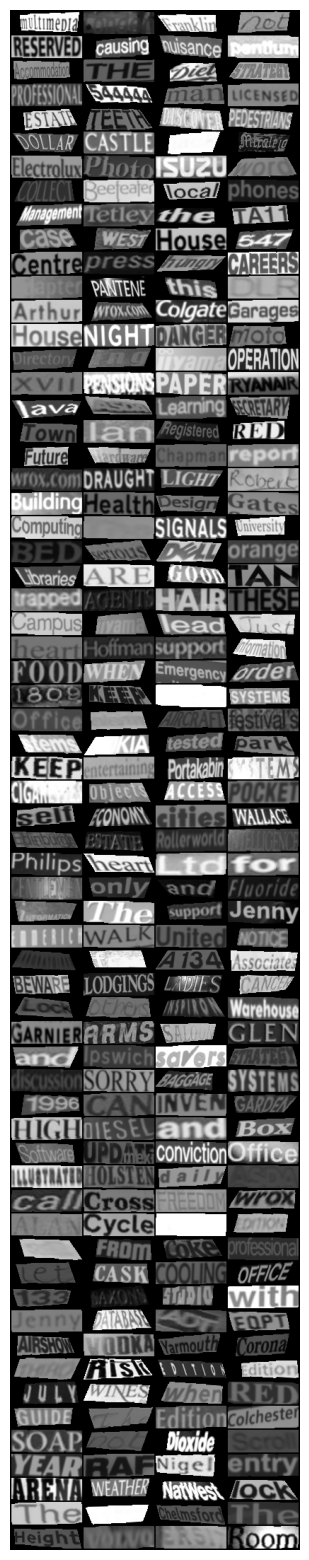

In [21]:
train_features, train_labels, train_lengths = next(iter(train_loader))

# use torchvision to display a grid of images
def show_batch(imgs, labels):
    labels = decode(labels, idx_to_char)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    print(labels)
    plt.show()

show_batch(train_features, train_labels)

# II. Text Regconition

## 1. CRNN

###  1.1 Model architecture

![Screen Shot 2024-04-20 at 09.22.48.png](<attachment:Screen Shot 2024-04-20 at 09.22.48.png>)
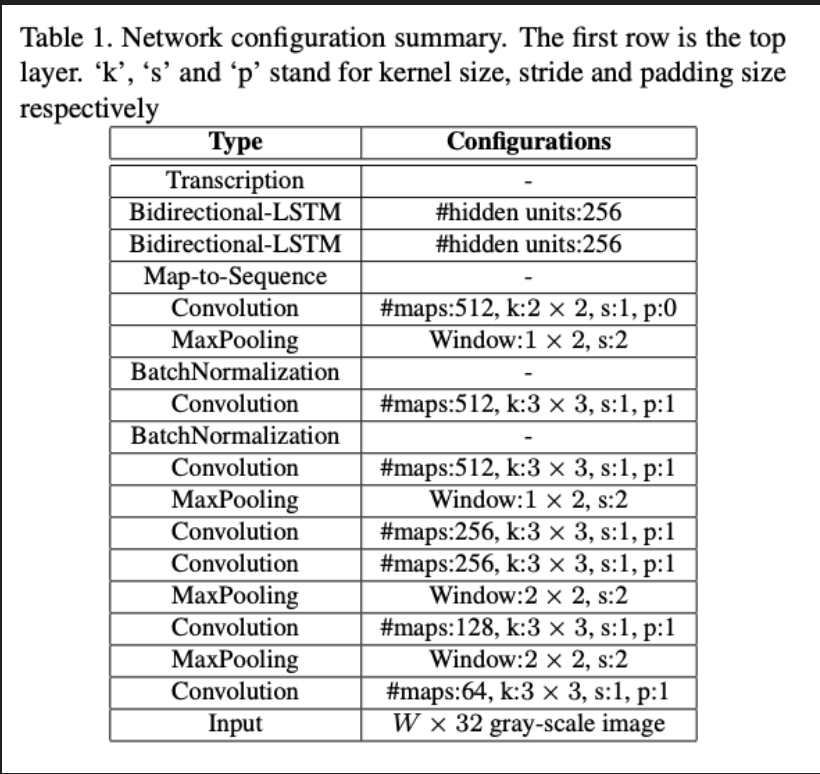

In [23]:
class CRNN(nn.Module):
    def __init__(
        self, 
        in_channels,
        vocab_size,
        hidden_size,
        n_layers,
        dropout=0.2
    ):
        super(CRNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        ) 

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1))
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1))
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True),
        )
        
        self.mapSeq = nn.Linear(512, 64)
        
        self.lstm = nn.LSTM(
            64, hidden_size,
            num_layers=n_layers,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0
        )
        #self.dropout = nn.Dropout(dropout)
        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),  
            nn.LogSoftmax(dim=2) 
        )
                                  
                                  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)         
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)  
        batch, channel, height, width = x.size()
        x = x.view(batch, channel * height, width)
        x = x.permute(2, 0, 1)
        x = self.mapSeq(x)
        x, _ = self.lstm(x)
        #x = self.dropout(x)
        x = self.out(x)
        
        return x 

In [24]:
in_channels = 1
hidden_size = 400
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_CRNN = CRNN(
    in_channels=in_channels,
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob
).to(device)

In [79]:
model_CRNN.eval()

dummy_tensor = torch.rand((64, 1, 32, 100)).to(device)

with torch.no_grad():
    output = model_CRNN(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([26, 64, 37])


### 1.2 Model training

In [25]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for inputs, labels, labels_len in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            # Tính len của model outputs
            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            loss = criterion(
                outputs, labels, logits_lens, labels_len
            )
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

In [26]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Tính len của model outputs
            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels, logits_lens, labels_len)
            loss.backward()
            # Thực hiện gradient clipping
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                5
            )
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

        scheduler.step()

    return train_losses, val_losses

In [27]:
epochs = 1000
lr = 0.001
weight_decay=1e-5
scheduler_step_size = epochs * 0.8

criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True
)
optimizer = torch.optim.Adam(
    model_CRNN.parameters(),
    lr=lr,
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [83]:
train_losses_CRNN, val_losses_CRNN = fit(
    model_CRNN,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 10.8932	Val loss: 8.6014
EPOCH 2:	Train loss: 4.0569	Val loss: 3.6287
EPOCH 3:	Train loss: 3.6582	Val loss: 3.5190
EPOCH 4:	Train loss: 3.4737	Val loss: 3.5644
EPOCH 5:	Train loss: 3.4421	Val loss: 3.5433
EPOCH 6:	Train loss: 3.5055	Val loss: 3.5789
EPOCH 7:	Train loss: 3.4373	Val loss: 3.5314
EPOCH 8:	Train loss: 3.4672	Val loss: 3.5034
EPOCH 9:	Train loss: 3.4126	Val loss: 3.5265
EPOCH 10:	Train loss: 3.4459	Val loss: 3.5607
EPOCH 11:	Train loss: 3.4304	Val loss: 3.4930
EPOCH 12:	Train loss: 3.4249	Val loss: 3.5186
EPOCH 13:	Train loss: 3.4393	Val loss: 3.5236
EPOCH 14:	Train loss: 3.4499	Val loss: 3.5787
EPOCH 15:	Train loss: 3.4717	Val loss: 3.5143
EPOCH 16:	Train loss: 3.4375	Val loss: 3.5137
EPOCH 17:	Train loss: 3.4372	Val loss: 3.5375
EPOCH 18:	Train loss: 3.4664	Val loss: 3.6285
EPOCH 19:	Train loss: 3.5264	Val loss: 3.6292
EPOCH 20:	Train loss: 3.5522	Val loss: 3.6568
EPOCH 21:	Train loss: 3.5486	Val loss: 3.5784
EPOCH 22:	Train loss: 3.4842	Val loss: 3.5

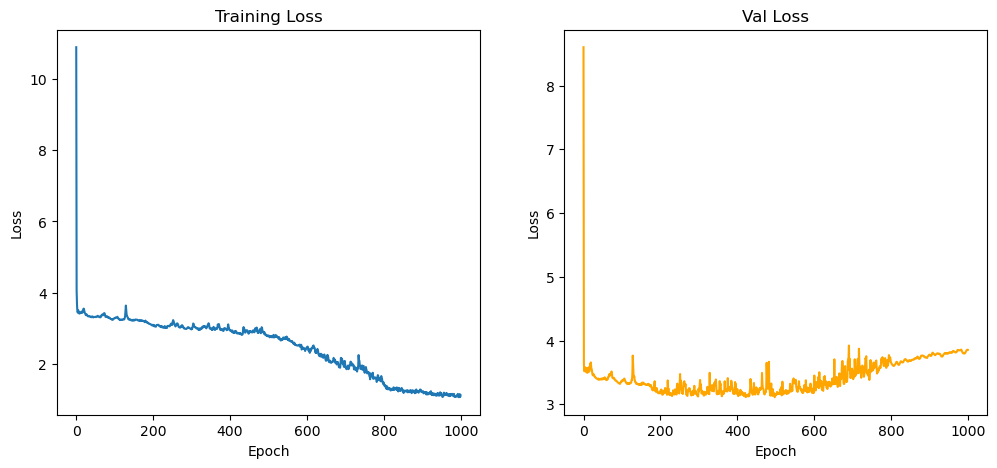

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses_CRNN)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses_CRNN, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

### 1.3. Evaluation

In [85]:
val_loss = evaluate(
    model_CRNN,
    val_loader,
    criterion,
    device
)
test_loss = evaluate(
    model_CRNN,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val loss: ', val_loss)
print('Test loss: ', test_loss)

Evaluation on val/test dataset
Val loss:  3.8544673919677734
Test loss:  3.8736937244733176


### 1.4. Make predictions

In [86]:
def predict(model, img):
    model.val()
    with torch.no_grad():
        outputs = model(img)
        print(outputs)

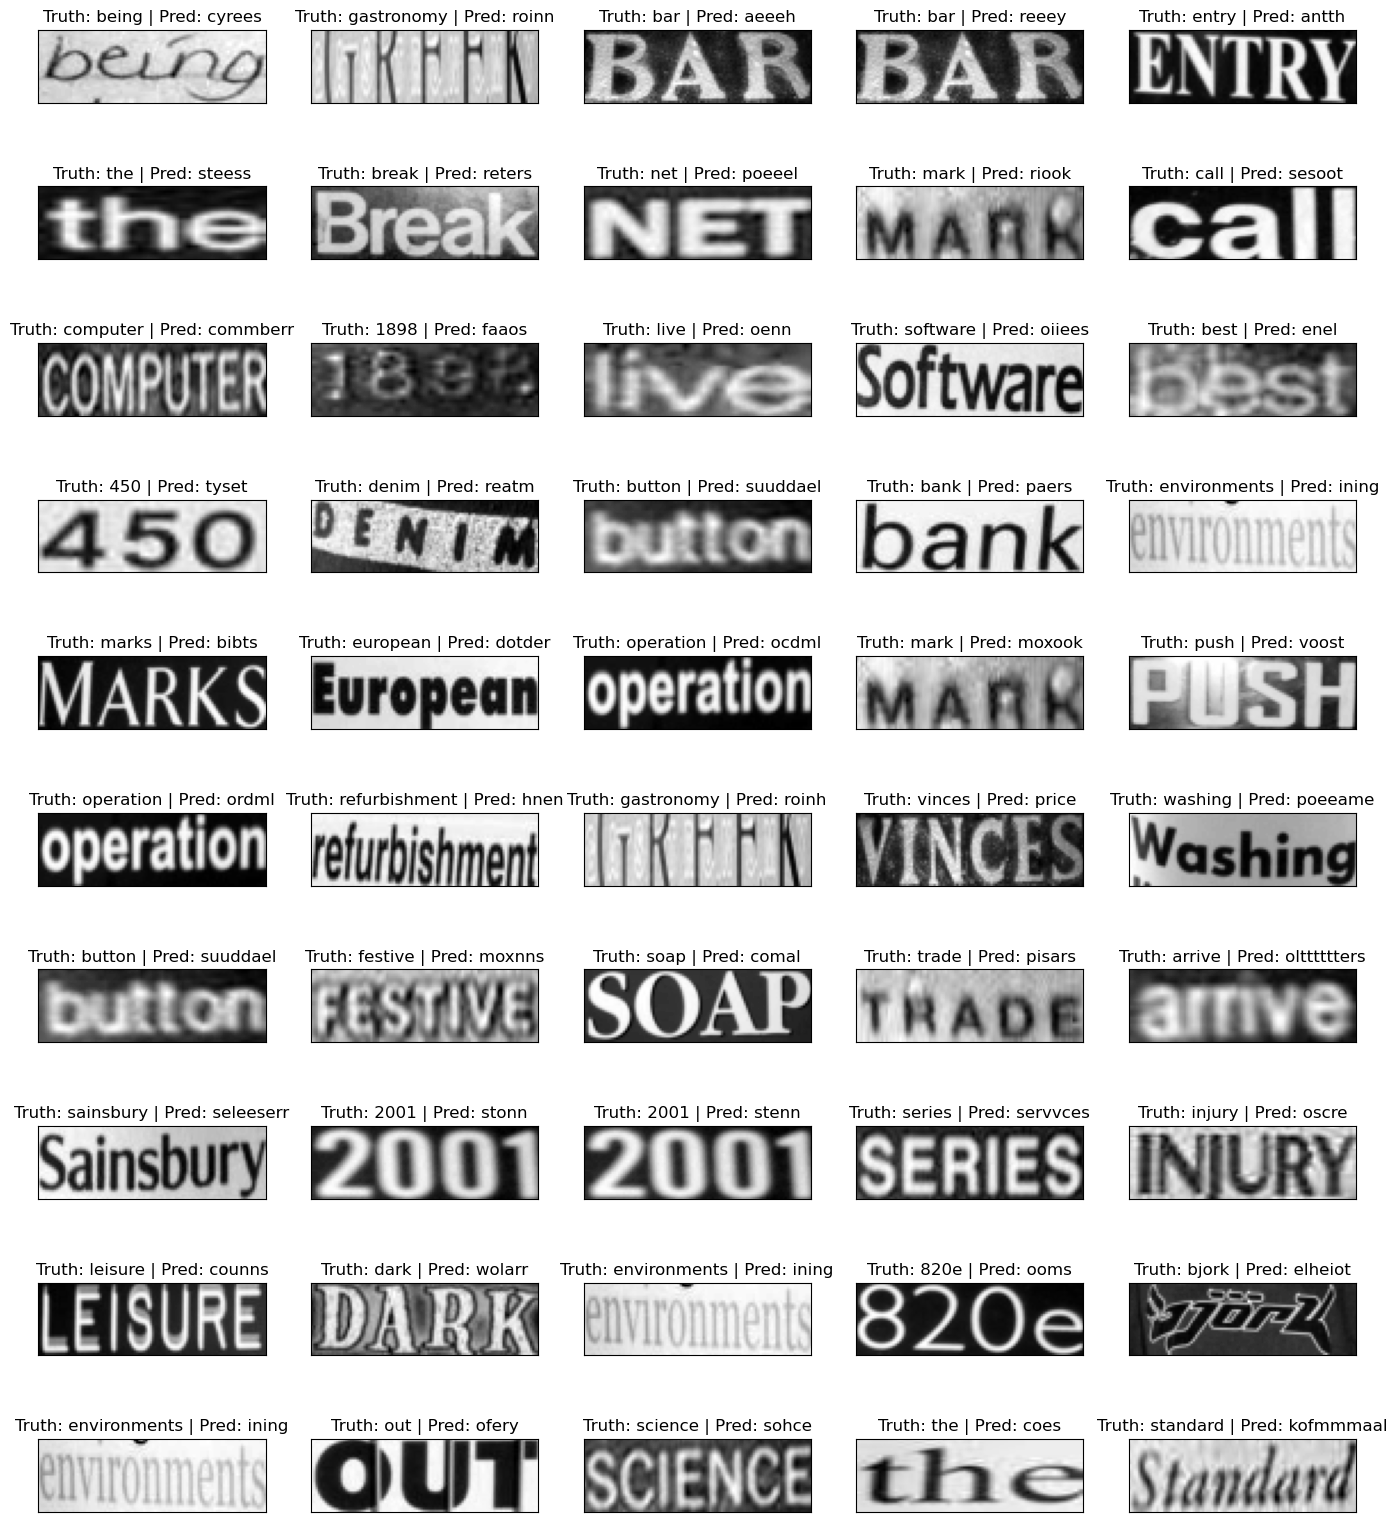

In [106]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(val_dataset))
    img, label, label_len = val_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode([label], idx_to_char)[0]
    logits = model_CRNN(img.unsqueeze(0))
    
    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f'Truth: {label} | Pred: {pred_text}'

    ax.imshow(img.permute(1, 2, 0), cmap='gray')
    ax.set_title(title)

plt.show()

### 1.5. Save model

In [108]:
save_model_path = 'Models/ocr_crnn_plain_best.pt'
torch.save(
    model.state_dict(), 
    save_model_path
)

## 2. CRNN + Skip Connection

### 2.1. Model Architecture

In [43]:
class CRNN_Skip_conn(nn.Module):
    def __init__(self, in_channels, vocab_size, hidden_size, n_layers, dropout=0.2):
        super(CRNN_Skip_conn, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.conv3_0 = nn.Conv2d(128, 256, kernel_size=1)  # This layer adjusts channels from 128 to 256
        self.conv3_1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d((2, 2), (2, 1), (0, 1))

        self.conv4_0 = nn.Conv2d(256, 512, kernel_size=1)  # This layer adjusts channels from 256 to 512
        self.conv4_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.maxpool4 = nn.MaxPool2d((2, 2), (2, 1), (0, 1))

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True),
        )
        
        self.mapSeq = nn.Linear(512, 64)
        
        self.lstm = nn.LSTM(
            64, hidden_size,
            num_layers=n_layers,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0
        )
        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),
            nn.LogSoftmax(dim=2)
        )
                                  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.conv3_0(x)  # Ensure this adjustment happens before conv3_1
        residual = x
        x = self.conv3_1(x)
        x = self.relu(x)
        x = self.conv3_2(x)
        x += residual  # Adding the skip connection
        x = self.relu(x)
        x = self.maxpool3(x)

        x = self.conv4_0(x)  # Ensure this adjustment happens before conv4_1
        residual = x
        x = self.conv4_1(x)
        x = self.bn4_1(x)
        x = self.relu(x)
        x = self.conv4_2(x)
        x = self.bn4_2(x)
        x += residual  # Adding the skip connection
        x = self.relu(x)
        x = self.maxpool4(x)

        x = self.conv5(x)
        batch, channel, height, width = x.size()
        x = x.view(batch, channel * height, width)
        x = x.permute(2, 0, 1)
        x = self.mapSeq(x)
        x, _ = self.lstm(x)
        x = self.out(x)
        
        return x


In [29]:
"""
Key Changes and Notes:
Skip Connections: Added around the conv3 and conv4 layers. The input (residual) to these blocks is added back to the output after the convolutional operations.
ReLU after Addition: It's important to apply the ReLU activation after adding the skip connections. This follows the typical pattern in ResNet and helps in maintaining non-linearity.
Compatibility of Dimensions: Ensure that the dimensions of the input and output of any layer where you apply a skip connection are the same. This is crucial for the element-wise addition to work.
"""

"\nKey Changes and Notes:\nSkip Connections: Added around the conv3 and conv4 layers. The input (residual) to these blocks is added back to the output after the convolutional operations.\nReLU after Addition: It's important to apply the ReLU activation after adding the skip connections. This follows the typical pattern in ResNet and helps in maintaining non-linearity.\nCompatibility of Dimensions: Ensure that the dimensions of the input and output of any layer where you apply a skip connection are the same. This is crucial for the element-wise addition to work.\n"

### 2.2. Training

In [44]:
in_channels = 1
hidden_size = 512
n_layers = 2
dropout_prob_2 = 0.4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_CRNN_skip_conn = CRNN_Skip_conn(
    in_channels=in_channels,
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob_2
).to(device)

In [45]:
model_CRNN_skip_conn.eval()

dummy_tensor = torch.rand((64, 1, 32, 100)).to(device)

with torch.no_grad():
    output = model_CRNN_skip_conn(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([26, 64, 37])


In [51]:
criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True
)
optimizer = torch.optim.Adam(
    model_CRNN_skip_conn.parameters(),
    lr=lr,
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [54]:
epochs = 500
lr = 0.001
weight_decay=1e-5
scheduler_step_size = epochs * 0.8
train_losses_CRNN_skip_conn, val_losses_CRNN_skip_conn = fit(
    model_CRNN_skip_conn,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 10.3553	Val loss: 3.8274
EPOCH 2:	Train loss: 5.1194	Val loss: 3.6330
EPOCH 3:	Train loss: 4.4198	Val loss: 6.6784
EPOCH 4:	Train loss: 5.9437	Val loss: 4.9632
EPOCH 5:	Train loss: 4.1743	Val loss: 3.7677
EPOCH 6:	Train loss: 3.7440	Val loss: 3.8612
EPOCH 7:	Train loss: 3.6806	Val loss: 3.5770
EPOCH 8:	Train loss: 3.5111	Val loss: 3.7337
EPOCH 9:	Train loss: 3.6082	Val loss: 3.5928
EPOCH 10:	Train loss: 3.4669	Val loss: 3.5743
EPOCH 11:	Train loss: 3.5060	Val loss: 3.5597
EPOCH 12:	Train loss: 3.4976	Val loss: 3.5854
EPOCH 13:	Train loss: 3.5250	Val loss: 3.6546
EPOCH 14:	Train loss: 3.5349	Val loss: 3.5760
EPOCH 15:	Train loss: 3.4689	Val loss: 3.5439
EPOCH 16:	Train loss: 3.4570	Val loss: 3.5338
EPOCH 17:	Train loss: 3.4574	Val loss: 3.5209
EPOCH 18:	Train loss: 3.4304	Val loss: 3.4836
EPOCH 19:	Train loss: 3.4016	Val loss: 3.4646
EPOCH 20:	Train loss: 3.3771	Val loss: 3.4519
EPOCH 21:	Train loss: 3.3637	Val loss: 3.4365
EPOCH 22:	Train loss: 3.3528	Val loss: 3.4

In [55]:
def save_checkpoint(model, optimizer, scheduler, epoch, loss, file_name):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss
    }, file_name)

# Call this function after your initial 500 epochs training
save_checkpoint(
    model=model_CRNN_skip_conn, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    epoch=500,
    loss=val_losses_CRNN_skip_conn[-1],
    file_name= "CRNN_skip_conn_500epochs"  # Assuming you track validation loss and want to save the last one
)


In [56]:
def load_checkpoint(file_name):
    checkpoint = torch.load(file_name)
    model_CRNN_skip_conn.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss

# Load the checkpoint
loaded_epoch, loaded_loss = load_checkpoint(file_name= "CRNN_skip_conn_500epochs")

# Make sure everything is loaded correctly and set to the correct device
model_CRNN_skip_conn.to(device)
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

In [57]:
# Now continue training for additional epochs
additional_epochs = 500
additional_train_losses, additional_val_losses = fit(
    model=model_CRNN_skip_conn,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=additional_epochs
)


EPOCH 1:	Train loss: 3.0240	Val loss: 3.1501
EPOCH 2:	Train loss: 3.0082	Val loss: 3.1469
EPOCH 3:	Train loss: 3.0145	Val loss: 3.1444
EPOCH 4:	Train loss: 3.0319	Val loss: 3.1408
EPOCH 5:	Train loss: 3.0172	Val loss: 3.3643
EPOCH 6:	Train loss: 3.0288	Val loss: 3.2809
EPOCH 7:	Train loss: 3.0276	Val loss: 3.1659
EPOCH 8:	Train loss: 3.0110	Val loss: 3.1395
EPOCH 9:	Train loss: 3.0217	Val loss: 3.1449
EPOCH 10:	Train loss: 3.0015	Val loss: 3.1424
EPOCH 11:	Train loss: 2.9913	Val loss: 3.1393
EPOCH 12:	Train loss: 3.0000	Val loss: 3.1340
EPOCH 13:	Train loss: 2.9944	Val loss: 3.1371
EPOCH 14:	Train loss: 2.9994	Val loss: 3.1370
EPOCH 15:	Train loss: 3.0004	Val loss: 3.1368
EPOCH 16:	Train loss: 3.0027	Val loss: 3.1403
EPOCH 17:	Train loss: 2.9916	Val loss: 3.1350
EPOCH 18:	Train loss: 2.9905	Val loss: 3.1615
EPOCH 19:	Train loss: 2.9952	Val loss: 3.1348
EPOCH 20:	Train loss: 2.9981	Val loss: 3.1256
EPOCH 21:	Train loss: 2.9987	Val loss: 3.1370
EPOCH 22:	Train loss: 2.9878	Val loss: 3.11

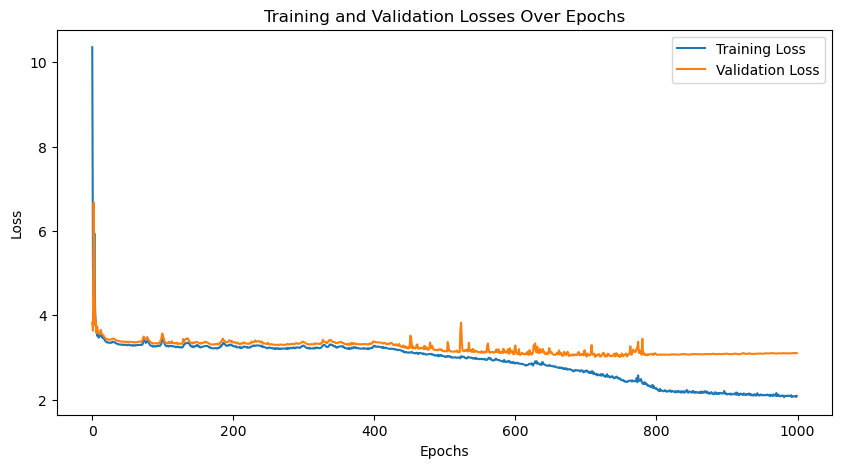

In [58]:
# Concatenate the training and validation losses
final_train_losses = train_losses_CRNN_skip_conn + additional_train_losses
final_val_losses = val_losses_CRNN_skip_conn + additional_val_losses

# Plotting the concatenated training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(final_train_losses, label='Training Loss')
plt.plot(final_val_losses, label='Validation Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 2.3. Evaluation

In [59]:
val_loss = evaluate(
    model_CRNN_skip_conn,
    val_loader,
    criterion,
    device
)
test_loss = evaluate(
    model_CRNN_skip_conn,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val loss: ', val_loss)
print('Test loss: ', test_loss)

Evaluation on val/test dataset
Val loss:  3.099226931730906
Test loss:  3.401350279649099


### 2.4. Make predictions

In [60]:
def predict(model, img):
    model.val()
    with torch.no_grad():
        outputs = model(img)
        print(outputs)

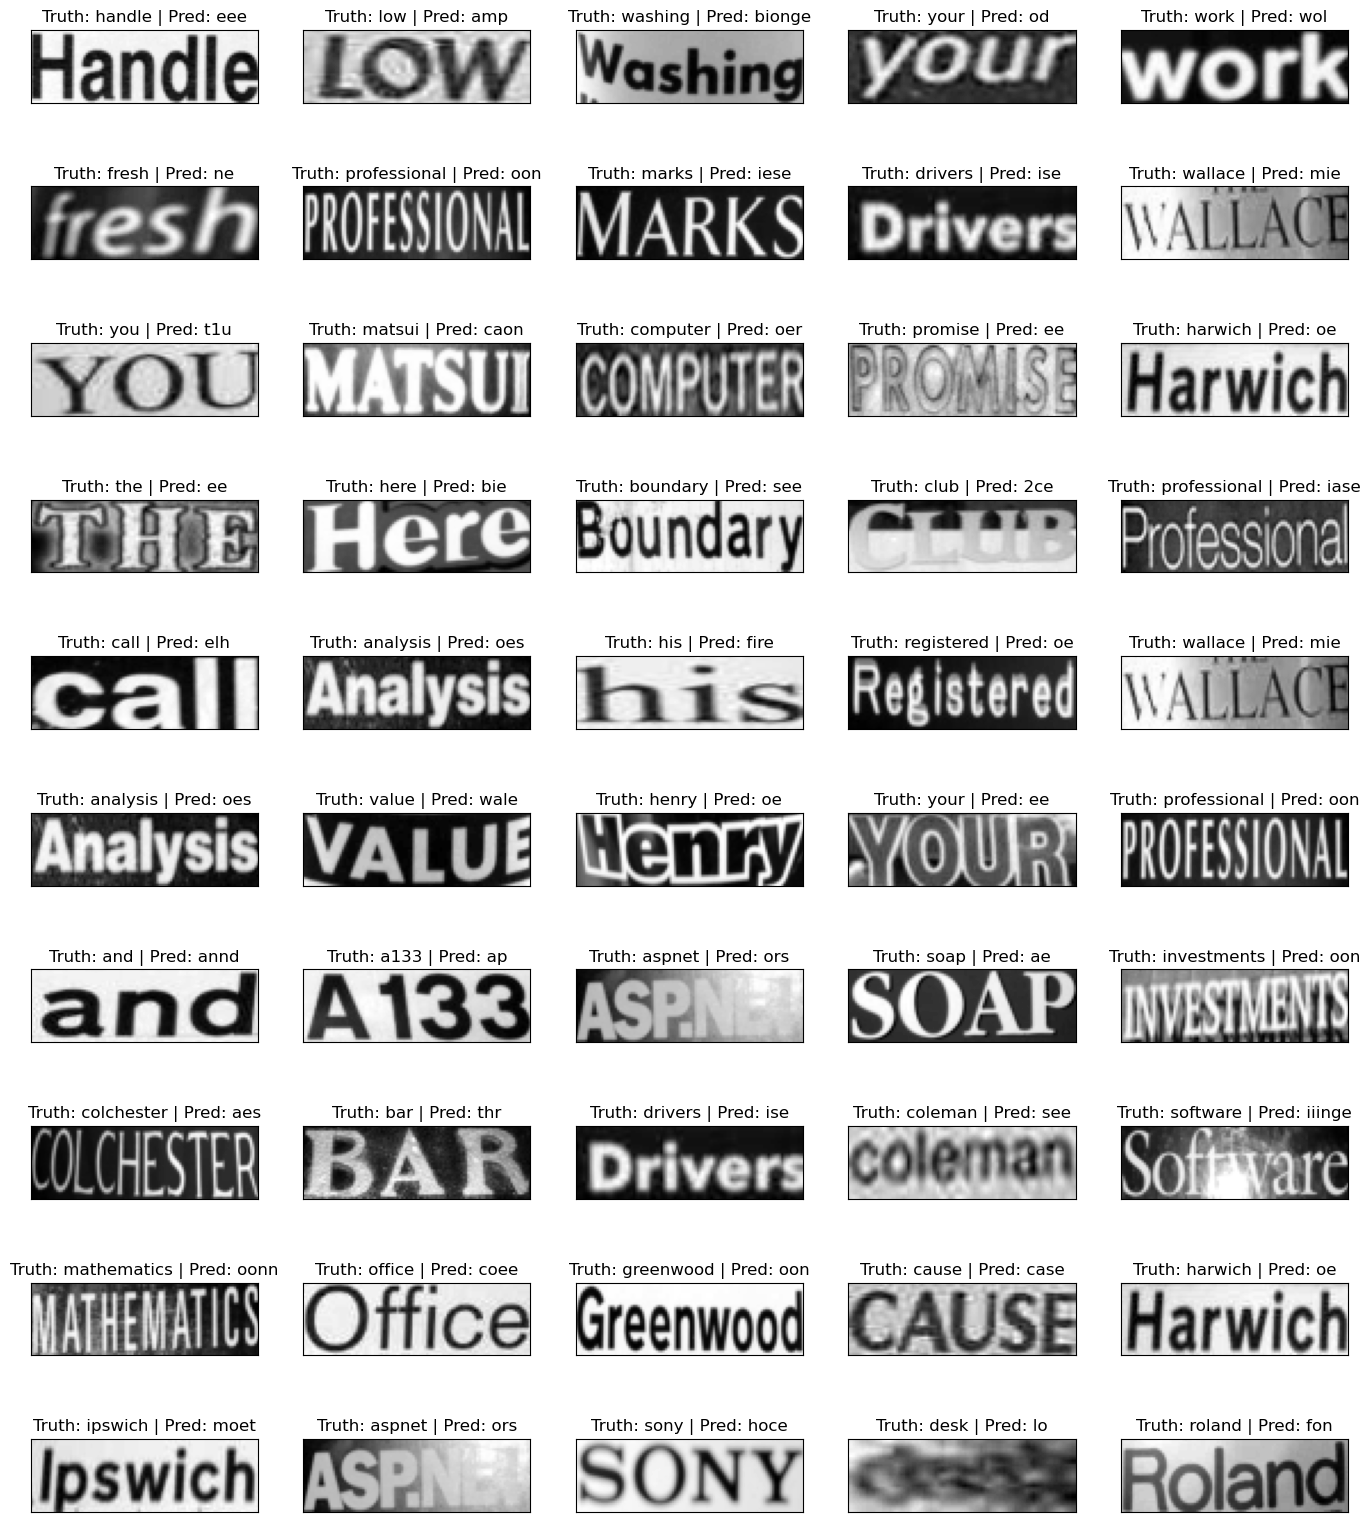

In [64]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(val_dataset))
    img, label, label_len = val_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode([label], idx_to_char)[0]
    logits = model_CRNN_skip_conn(img.unsqueeze(0))
    
    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f'Truth: {label} | Pred: {pred_text}'

    ax.imshow(img.permute(1, 2, 0), cmap='gray')
    ax.set_title(title)

plt.show()

### 2.5. Save model

In [65]:
save_model_path = 'Models/CRNN_skip_conn_best.pt'
torch.save(
    model_CRNN_skip_conn.state_dict(), 
    save_model_path
)

## 3. CRNN Resnet

### 3.1. Model architecture

In [28]:
class CRNN_Resnet (nn.Module):
    def __init__ (
        self,
        vocab_size,
        hidden_size,
        n_layers,
        dropout=0.2,
        unfreeze_layers=3
    ):
        super (CRNN_Resnet, self).__init__()

        # Initialize pretrained model resnet 101
        backbone = timm.create_model (
            'resnet101',
            in_chans=1,
            pretrained=True
        )

        # Remove original classifier layer
        modules = list(backbone.children())[:-2]

        # Add an Adaptive Average Pooling layer
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Unfreeze some last layers of pretrained model
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.require_grad = True

        # Layer to map feature maps of CNN to LSTM
        self.mapSeq = nn.Sequential (
            nn.Linear (2048, 1024),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.lstm = nn.LSTM (
            1024, hidden_size,
            n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.out = nn.Sequential (
            nn.Linear (hidden_size*2, vocab_size),
            nn.LogSoftmax(dim=2)
        )

    def forward(self, x):
        x = self.backbone(x) # shape: (bs, c, h, w)
        x = x.permute(0, 3, 1, 2) # shape: (bs, w, c, h)
        x = x.view(x.size(0), x.size(1), -1)  # Remove h: (bs, w, c)
        x = self.mapSeq(x) 
        x, _ = self.lstm(x)
        x = self.layer_norm(x)
        x = self.out(x) # shape: (bs, seq_len, n_classes)
        x = x.permute(1, 0, 2) # Based on CTC # (seq_len, bs, n_classes)
         
        return x

In [29]:
hidden_size = 256
n_layers = 2
dropout_prob = 0.3
unfreeze_layers=3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_CRNN_Resnet = CRNN_Resnet(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers
).to(device)

In [30]:
model_CRNN_Resnet.eval()

dummy_tensor = torch.rand((64, 1, 100, 420)).to(device)

with torch.no_grad():
    output = model_CRNN_Resnet(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([14, 64, 37])


### 3.2. Model training

In [31]:
epochs = 200
lr = 0.001
weight_decay=1e-5
scheduler_step_size = epochs * 0.5

criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char], 
    zero_infinity=True
)
optimizer = torch.optim.Adam(
    model_CRNN_Resnet.parameters(), 
    lr=lr, 
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=scheduler_step_size, 
    gamma=0.1
)

In [32]:
train_losses, val_losses = fit(
    model_CRNN_Resnet,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 0.9754	Val loss: 1.2753
EPOCH 2:	Train loss: 0.8970	Val loss: 1.2016
EPOCH 3:	Train loss: 0.8647	Val loss: 1.1642
EPOCH 4:	Train loss: 0.8125	Val loss: 1.1548
EPOCH 5:	Train loss: 0.8471	Val loss: 1.1298
EPOCH 6:	Train loss: 0.7930	Val loss: 1.1072
EPOCH 7:	Train loss: 0.7882	Val loss: 1.0702
EPOCH 8:	Train loss: 0.7410	Val loss: 1.0347
EPOCH 9:	Train loss: 0.7333	Val loss: 1.0220
EPOCH 10:	Train loss: 0.6939	Val loss: 1.0817
EPOCH 11:	Train loss: 0.6433	Val loss: 1.0523
EPOCH 12:	Train loss: 0.6687	Val loss: 1.0528
EPOCH 13:	Train loss: 0.6352	Val loss: 1.0276
EPOCH 14:	Train loss: 0.5957	Val loss: 1.0245
EPOCH 15:	Train loss: 0.5880	Val loss: 1.0180
EPOCH 16:	Train loss: 0.5193	Val loss: 1.0675
EPOCH 17:	Train loss: 0.4755	Val loss: 1.0842
EPOCH 18:	Train loss: 0.4833	Val loss: 1.1173
EPOCH 19:	Train loss: 0.4311	Val loss: 1.1409
EPOCH 20:	Train loss: 0.4365	Val loss: 1.1462
EPOCH 21:	Train loss: 0.3737	Val loss: 1.1675
EPOCH 22:	Train loss: 0.3819	Val loss: 1.16

: 

### 3.3. Evaluation

In [ ]:
val_loss = evaluate(
    model_CRNN_Resnet,
    val_loader,
    criterion,
    device
)
test_loss = evaluate(
    model_CRNN_Resnet,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val loss: ', val_loss)
print('Test loss: ', test_loss)

### 3.4. Make predictions

### 3.5. Save model